In [15]:
"""
Customer Churn Prediction (MLOps Exploring)
Author: Lutfihadi
Remarks: This script compares multiple models and logs them via MLflow.
          Also tested threshold tuning manually to balance recall and precision.
"""


#Importing prereq libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import mlflow
import mlflow.sklearn

In [16]:
# Load dataset
df = pd.read_csv(r"C:\MLCourse\customer_churn_mlops\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick check
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
# Clean and prepare raw data
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

df.drop('customerID', axis=1, inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Splitting and encoding(train_test_split)
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"✅ Cleaned shape: {df.shape}")
print(f"Churn distribution:\n{df['Churn'].value_counts()}")
print(f"Churn rate: {df['Churn'].mean():.2%}")

✅ Cleaned shape: (7043, 20)
Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5634, 19)
Test shape: (1409, 19)


In [19]:
# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np

# Categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Set MLflow experiment
mlflow.set_experiment("customer_churn_prediction_ARTIFACTS")

# Models and their hyperparameters
models = {
    "logistic_regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "classifier__C": [0.1, 1.0, 10.0],
            "classifier__penalty": ['l2'],
            "classifier__class_weight": ['balanced', None]
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [10, 20, None],
            "classifier__min_samples_split": [2, 5],
            "classifier__class_weight": ['balanced', None]
        }
    },
    "gradient_boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.01, 0.1],
            "classifier__max_depth": [3, 5],
            "classifier__subsample": [0.8, 1.0]
        }
    },
    "xgboost": {
        "model": XGBClassifier(random_state=42, eval_metric='logloss'),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.01, 0.1],
            "classifier__max_depth": [3, 5, 7],
            "classifier__scale_pos_weight": [1, 3]  # for imbalanced data
        }
    }
}

# Store results for comparison
results = []

# Train 
for model_name, model_config in models.items():
    print(f"\n--- Training {model_name} ---")
    
    with mlflow.start_run(run_name=f"{model_name}_with_tuning"):
        # Create pipeline
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model_config["model"])
        ])
        
        
        grid_search = GridSearchCV(
            pipeline,
            model_config["params"],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Predict
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Met Eval
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        
        print(f"Best Params → {grid_search.best_params_}")
        print(f"Metrics: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}")

        
        # MLflow log
        mlflow.log_param("model_type", model_name)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", auc)
        mlflow.log_metric("cv_best_score", grid_search.best_score_)
        mlflow.sklearn.log_model(best_model, "model")
        
        # Storing
        results.append({
            "model": model_name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "roc_auc": auc,
            "best_params": grid_search.best_params_
        })

# Comparing 
results_df = pd.DataFrame(results).sort_values('f1_score', ascending=False)

print("\nModel performance summary (sorted by F1):\n")
print(results_df[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

best_model_name = results_df.iloc[0]['model']
best_f1 = results_df.iloc[0]['f1_score']

print(f"\nBest performer → {best_model_name.upper()} | F1: {best_f1:.4f}\n")

# Save comparison for reference
results_df.to_csv("model_comparison.csv", index=False)

# Log summary to MLflow
with mlflow.start_run(run_name="model_comparison"):
    mlflow.log_artifact("model_comparison.csv")
    mlflow.log_metric("best_f1_score", best_f1)
    mlflow.log_param("best_model", best_model_name)

print("Comparison saved and logged to MLflow ✅")



--- Training logistic_regression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025/10/21 00:25:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params → {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Metrics: acc=0.752, f1=0.639, auc=0.862


2025/10/21 00:25:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Training random_forest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/10/21 00:26:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params → {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Metrics: acc=0.781, f1=0.644, auc=0.861


2025/10/21 00:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Training gradient_boosting ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/10/21 00:26:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params → {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Metrics: acc=0.817, f1=0.622, auc=0.859


2025/10/21 00:26:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Training xgboost ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/10/21 00:27:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params → {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 3}
Metrics: acc=0.754, f1=0.648, auc=0.859


2025/10/21 00:27:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model performance summary (sorted by F1):

                 model  accuracy  precision    recall  f1_score   roc_auc
3              xgboost  0.754436   0.522167  0.852547  0.647658  0.858952
1        random_forest  0.780696   0.564516  0.750670  0.644419  0.860781
0  logistic_regression  0.752307   0.520202  0.828418  0.639090  0.861989
2    gradient_boosting  0.816891   0.686084  0.568365  0.621701  0.859318

Best performer → XGBOOST | F1: 0.6477

Comparison saved and logged to MLflow ✅



Best threshold = 0.578 (F1 = 0.656)

Threshold comparison:
                Accuracy  Precision    Recall        F1
Default (0.5)  0.754436   0.522167  0.852547  0.647658
Tuned (0.578)  0.782115   0.563462  0.785523  0.656215

Plot saved: threshold_optimization.png

F1 change: +0.009 (after adjusting threshold)
Precision/recall shifted as expected.


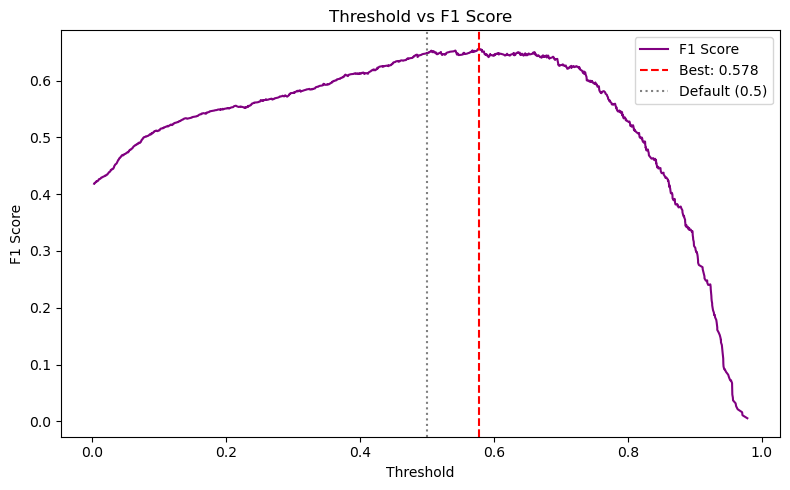

In [22]:
# Threshold optimization
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlflow

# Load model & predict churn probs
model_uri = "runs:/1344fffe0b7147fbace90cedccc60759/model"
model = mlflow.sklearn.load_model(model_uri)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Threshold finding
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
f1_scores = f1_scores[:-1] 
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest threshold = {best_threshold:.3f} (F1 = {best_f1:.3f})")

# Compare default 0.5 vs tuned threshold
y_pred_default = (y_pred_proba >= 0.5).astype(int)
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

def evaluate(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

default_metrics = evaluate(y_test, y_pred_default)
tuned_metrics = evaluate(y_test, y_pred_best)

summary = pd.DataFrame([default_metrics, tuned_metrics], index=["Default (0.5)", f"Tuned ({best_threshold:.3f})"])
print("\nThreshold comparison:\n", summary)

# Visualization
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label="F1 Score", color="purple")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best: {best_threshold:.3f}")
plt.axvline(0.5, color="gray", linestyle=":", label="Default (0.5)")
plt.xlabel("Threshold"); plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.legend()
plt.tight_layout()
plt.savefig("threshold_optimization.png", dpi=300)
print("\nPlot saved: threshold_optimization.png")

# Interpretation
delta = tuned_metrics["F1"] - default_metrics["F1"]
print(f"\nF1 change: {delta:+.3f} (after adjusting threshold)")
print("Precision/recall shifted as expected.")

